In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import lightning.pytorch as pl
from torch.utils.data import TensorDataset, DataLoader

from torchmetrics.functional import accuracy
from torchmetrics import F1Score

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

In [2]:
bank_customer_churn_data = pd.read_csv("Churn_Modelling.csv")
bank_customer_churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [3]:
bank_customer_churn_data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [4]:
bank_customer_churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


In [5]:
# fields like row number, id, surname doesn't help for the predictions
# null columns are not useful, so the respective row can be ignored
bank_customer_churn_data.dropna(inplace = True)
bank_customer_churn_data = bank_customer_churn_data.drop_duplicates()
bank_customer_churn_data.shape

(9996, 14)

In [6]:
# It is binary classification model, i,e. predicts customer will exit or not
bank_customer_churn_data["Exited"].value_counts()

Exited
0    7959
1    2037
Name: count, dtype: int64

<Axes: xlabel='Exited', ylabel='count'>

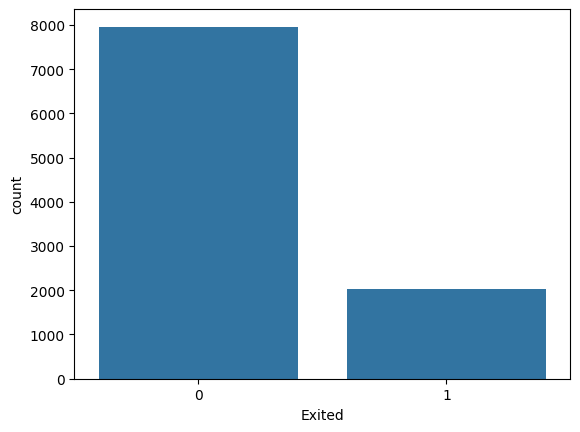

In [7]:
# the data is skewed, that is customer exited is about 80% and not exited is 20%
# show in a graph
sns.countplot(data = bank_customer_churn_data, x = "Exited")

# training model on skewed data will not perform well
# usual method is to balance the data to train the model
# lets not do any balancing data, continue learn pytorch lightning

In [9]:
# lets create data module

class BankCustomerChurnDataModule(pl.LightningDataModule):
    def __init__(self, batch_size: int = 8):
        super().__init__()

        self.batch_size = batch_size

    def prepare_data(self):
        self.bank_customer_churn_data = pd.read_csv("Churn_Modelling.csv")

        self.bank_customer_churn_data = self.bank_customer_churn_data.dropna()
        self.bank_customer_churn_data = self.bank_customer_churn_data.drop_duplicates()

    def setup(self, stage = None):
        X = self.bank_customer_churn_data.drop(
            columns = ["Exited", "RowNumber", "CustomerId", "Surname"]
        )
        Y = self.bank_customer_churn_data["Exited"]

        if stage == "fit" or stage is None:
            X_train, X_val, Y_train, Y_val = \
            train_test_split(X, Y, test_size = 0.2, random_state = 123)

            ## one hot encoding categorical features
            categorical_features = ["Geography", "Gender"]
            categorical_transformer = OneHotEncoder(
                handle_unknown = "ignore", drop = "first", sparse_output = False
            )
            preprocessor = ColumnTransformer(
                transformers = [("cat_tr", categorical_transformer, categorical_features)],
                remainder = "passthrough"
            )

            # transform the categorical features
            X_train = preprocessor.fit_transform(X_train)
            X_val = preprocessor.transform(X_val)
            # convert the Y values into numPy array
            Y_train, Y_val = np.array(Y_train), np.array(Y_val)

            # scaling inputs - standarize the numeric values
            scaler = StandardScaler()

            inputs_train_array = scaler.fit_transform(X_train)
            inputs_val_array = scaler.transform(X_val)

            # convert arrays and labels to tensors
            self.train_inputs = torch.from_numpy(inputs_train_array).float()
            self.train_targets = torch.from_numpy(Y_train.reshape(-1, 1)).float()
            self.val_inputs = torch.from_numpy(inputs_val_array).float()
            self.val_targets = torch.from_numpy(Y_val.reshape(-1, 1)).float()

    def train_dataloader(self):
        train_dataset = TensorDataset(self.train_inputs, self.train_targets)
        train_loader = DataLoader(
            dataset = train_dataset, batch_size = self.batch_size, num_workers = 4
        )
        return train_loader

    def val_dataloader(self):
        val_dataset = TensorDataset(self.val_inputs, self.val_targets)
        val_loader = DataLoader(
            dataset = val_dataset, batch_size = self.batch_size, num_workers = 4
        )
        return val_loader

# lets check if the data module set up correctly
bank_customer_churn_dm = BankCustomerChurnDataModule()  # batch_size default value is 8

bank_customer_churn_dm.prepare_data()
bank_customer_churn_dm.setup()

In [10]:
train_dl = bank_customer_churn_dm.train_dataloader()

sample_train_data_batch = next(iter(train_dl))
sample_train_data_batch

[tensor([[-5.7812e-01, -5.7465e-01,  9.0655e-01,  7.3023e-01, -3.7092e-01,
           1.7379e+00, -1.2208e+00,  8.1028e-01,  6.4321e-01, -1.0287e+00,
          -4.9144e-01],
         [-5.7812e-01, -5.7465e-01,  9.0655e-01, -1.6488e+00, -9.4915e-01,
          -3.4805e-01, -1.2208e+00,  8.1028e-01,  6.4321e-01, -1.0287e+00,
          -1.1807e+00],
         [-5.7812e-01, -5.7465e-01,  9.0655e-01,  8.3322e-01, -9.4915e-01,
          -3.9131e-04,  1.6494e+00, -9.1791e-01, -1.5547e+00, -1.0287e+00,
           2.1372e-01],
         [-5.7812e-01, -5.7465e-01,  9.0655e-01,  8.3322e-01, -7.5640e-01,
          -1.3910e+00,  8.9763e-01, -9.1791e-01,  6.4321e-01,  9.7212e-01,
           1.4954e+00],
         [-5.7812e-01, -5.7465e-01,  9.0655e-01,  2.0588e+00,  1.6529e+00,
           6.9493e-01,  8.7853e-01, -9.1791e-01,  6.4321e-01,  9.7212e-01,
           3.3874e-01],
         [ 1.7297e+00, -5.7465e-01, -1.1031e+00, -3.3054e-01, -9.4915e-01,
           1.7379e+00,  3.8292e-01,  8.1028e-01,  6.432

In [11]:
# check the number of features in the data,
# needed for setting up the layers in the model
num_features = sample_train_data_batch[0].shape[1]
num_features

11

In [12]:
# check if validation dataloader works
val_dl = bank_customer_churn_dm.val_dataloader()
next(iter(val_dl))

[tensor([[-5.7812e-01, -5.7465e-01,  9.0655e-01,  1.0289e+00, -8.1809e-02,
          -3.9131e-04,  1.2017e+00, -9.1791e-01,  6.4321e-01,  9.7212e-01,
          -9.2831e-01],
         [ 1.7297e+00, -5.7465e-01, -1.1031e+00,  5.4485e-01, -9.4915e-01,
          -6.9571e-01,  7.3093e-01, -9.1791e-01, -1.5547e+00,  9.7212e-01,
          -2.9551e-01],
         [-5.7812e-01, -5.7465e-01, -1.1031e+00,  2.0588e+00,  6.8916e-01,
          -6.9571e-01, -1.2208e+00,  8.1028e-01,  6.4321e-01,  9.7212e-01,
           1.5392e+00],
         [ 1.7297e+00, -5.7465e-01,  9.0655e-01,  9.3199e-03, -1.2383e+00,
          -3.9131e-04,  1.1298e+00, -9.1791e-01, -1.5547e+00, -1.0287e+00,
           7.3284e-01],
         [ 1.7297e+00, -5.7465e-01,  9.0655e-01,  1.2555e+00, -4.6729e-01,
           6.9493e-01,  5.6278e-01, -9.1791e-01,  6.4321e-01,  9.7212e-01,
           3.7185e-01],
         [-5.7812e-01, -5.7465e-01, -1.1031e+00, -2.6875e-01,  3.0984e+00,
          -3.4805e-01,  1.5010e+00,  2.5385e+00,  6.432

In [13]:
# lets create the model

class LitBinaryClassificationModule(pl.LightningModule):
    def __init__(self, num_features, learning_rate = 0.001):
        super().__init__()

        self.layer1 = nn.Linear(num_features, 16)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(16, 8)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(8, 4)
        self.act3 = nn.ReLU()
        self.output_layer = nn.Linear(4, 1)
        self.save_hyperparameters()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.output_layer(x)

        return x

    def training_step(self, batch, batch_idx):
        x, y = batch

        # invoke the forward pass
        logits = self(x)

        # compute the loss in terms of probabilities in range of 0 to 1
        # by comparing the predicted and actual values (y)
        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(logits, y)

        self.log("train_loss", loss, on_step = False, on_epoch = True, prog_bar = True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        logits = self(x)

        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(logits, y)

        # convert raw logits score into probability score in the range 0 to 1
        # using sigmoid function
        preds = torch.round(torch.sigmoid(logits))

        # compute the accuracy
        # note, we have skewed data, accuracy may not be a good measure
        acc = accuracy(preds, y, task = "binary")

        # compute F1 Score
        # this metrics is good measure for model that are trained in skewed data
        f1_score = F1Score(task = "binary")
        f1 = f1_score(preds, y)

        self.log(f"val_loss", loss, on_epoch = True, prog_bar = True)
        self.log(f"val_acc", acc, on_epoch = True, prog_bar = True)
        self.log(f"val_f1", f1, on_epoch = True, prog_bar = True)

    def predict_step(self, batch, batch_idx, dataloader_idx = 0):
        """
        predict_step gives the predictions from the model
        """
        x, y = batch
        # invoke the forward pass through the model
        return self(x)

    def configure_optimizers(self):
        # use adaptive model optimizer
        return torch.optim.Adam(self.parameters(), lr = self.hparams.learning_rate)

# Now instantiate the model
lit_clf_nn_model = LitBinaryClassificationModule(num_features = num_features)
print(lit_clf_nn_model)

LitBinaryClassificationModule(
  (layer1): Linear(in_features=11, out_features=16, bias=True)
  (act1): ReLU()
  (layer2): Linear(in_features=16, out_features=8, bias=True)
  (act2): ReLU()
  (layer3): Linear(in_features=8, out_features=4, bias=True)
  (act3): ReLU()
  (output_layer): Linear(in_features=4, out_features=1, bias=True)
)


In [14]:
# train the model
from pytorch_lightning.loggers import CSVLogger

bank_customer_churn_dm = BankCustomerChurnDataModule()
logger = CSVLogger("logs", name = "pytorch_lightning_classification")

trainer = pl.Trainer(max_epochs = 20, logger = logger)

trainer.fit(lit_clf_nn_model, datamodule = bank_customer_churn_dm)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type   | Params | Mode 
------------------------------------------------
0 | layer1       | Linear | 192    | train
1 | act1         | ReLU   | 0      | train
2 | layer2       | Linear | 136    | train
3 | act2         | ReLU   | 0      | train
4 | layer3       | Linear | 36     | train
5 | act3         | ReLU   | 0      | train
6 | output_layer | Linear | 5      | train
------------------------------------------------
369       Trainable params
0         Non-trainable params
369       Total params
0.001     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                      | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                             | 0/? [00:00<?, ?it/s]

Validation: |                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                           | 0/? [00:00<?, ?it/s]

Validation: |                                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [15]:
# check the metrics
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
metrics

,epoch,step,train_loss,val_acc,val_f1,val_loss
0,0,999,NaN,0.8110,0.252952,0.429178
1,0,999,0.446783,NaN,NaN,NaN
2,1,1999,NaN,0.8350,0.357362,0.396101
3,1,1999,0.392213,NaN,NaN,NaN
4,2,2999,NaN,0.8515,0.403206,0.370103
5,2,2999,0.364991,NaN,NaN,NaN
6,3,3999,NaN,0.8555,0.408898,0.359785
7,3,3999,0.349742,NaN,NaN,NaN
8,4,4999,NaN,0.8560,0.406920,0.355542
9,4,4999,0.343290,NaN,NaN,NaN


,train_loss,val_acc,val_f1,val_loss
epoch,,,,
0,NaN,0.8110,0.252952,0.429178
0,0.446783,NaN,NaN,NaN
1,NaN,0.8350,0.357362,0.396101
1,0.392213,NaN,NaN,NaN
2,NaN,0.8515,0.403206,0.370103


<Axes: xlabel='epoch'>

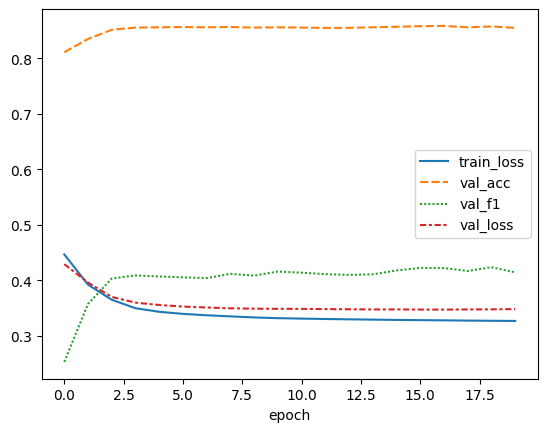

In [16]:
# show the metrics in seaborn line plot
del metrics["step"]
# set epoch column as the index, for easier plotting
metrics.set_index("epoch", inplace = True)
# display first few rows of the metrics table, excluding the NaN values
display(metrics.dropna(axis = 1, how = "all").head())

sns.lineplot(data = metrics)

In [ ]:
# get some predictions from the model
y_pred_stacked = torch.cat(
    trainer.predict(model = lit_clf_nn_model, dataloaders = bank_customer_churn_dm.val_dataloader())
)

y_pred_stacked[:10]

In [ ]:
# the predictions are unnormalized logits scores
# lets normalize it to probability score between 0 and 1
y_pred = torch.round(torch.sigmoid(y_pred_stacked))
y_pred[:10]

In [ ]:
# get the actual values from the validation data
labels = []

for data, label in bank_customer_churn_dm.val_dataloader():
    labels.extend(label)
# get them in single tensor
y_true = torch.stack(labels)
y_true[:10]

In [ ]:
# now we have predictions and actual values
# compute the evaluation metrics for the validation data

from torchmetrics.classification import BinaryAccuracy
from torchmetrics import Recall, Precision, F1Score

acc = BinaryAccuracy()
prec = Precision(task = "binary")
recall = Recall(task = "binary")
f1 = F1Score(task = "binary")

print("Accuracy score :", round(acc(y_pred, y_true).item(), 3))
print("Precision score :", round(prec(y_pred, y_true).item(), 3))
print("Recall score :", round(recall(y_pred, y_true).item(), 3))
print("F1 score :", round(f1(y_pred, y_true).item(), 3))

In [ ]:
print("hello")